In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import tensorflow as tf
import tensorflow.contrib.keras as keras

from tensorflow.contrib.keras import backend as K
from tensorflow.contrib.keras.python.keras.models import Sequential
from tensorflow.contrib.keras.python.keras.layers import Dense, Dropout, Flatten

In [16]:
from enum import Enum
import math
class Dataset(Enum):
    AND_GRID = 0 #Basic AND function
    BASIC_GRID = 1 #Basic grid 4x4 with 8xO and 8xX
    BOOL_FUNC = 2 #Boolean function of 5 variables
    POLYGON = 3 #Polygon shape dividing 2D grid to 2 classes
    MULTI_CLASS = 4 #Function dividing 2D grid to 8 classes
    ONE_DIM = 5 #One dimensional function
    ONE_DIM_MEMORY = 6 #One dimensional function with memory

def get_num_classes(dataset):
    n = 2
    if dataset == Dataset.MULTI_CLASS:
        n = 8
    elif dataset in [Dataset.ONE_DIM, Dataset.ONE_DIM_MEMORY]:
        n = 1
    return n

In [17]:
print("TensorFlow version =", tf.__version__)
print("Keras backend =", keras.backend.backend())
print("Default float type =", keras.backend.floatx())
print("Image data structure =", keras.backend.image_data_format())

TensorFlow version = 1.3.0
Keras backend = tensorflow
Default float type = float32
Image data structure = channels_last


In [39]:
def load_train_data(dataset, no_points):
    x_all = np.loadtxt('data/' + dataset.name + "_" + str(no_points) + '_xs.txt')
    print("Loaded",x_all.shape,"examples from", 'data/' + dataset.name + "_" + str(no_points) + '_xs.txt')
    y_all = np.loadtxt('data/' + dataset.name + "_" + str(no_points) + '_ys.txt')
    print("Loaded",y_all.shape,"labels from", 'data/' + dataset.name + "_" + str(no_points) + '_ys.txt')
    return x_all, y_all

In [42]:
def prepare_train_data(dataset, no_points=10000, train_ratio=0.7):
    print("Preparing training data for dataset", dataset.name)
    x_all, y_all = load_train_data(dataset, no_points)
    assert(x_all.shape[0] == y_all.shape[0])
    
    if x_all.ndim == 1:
        x_all = x_all.reshape((x_all.shape[0],1))
    z_all = np.append(x_all, y_all.reshape((y_all.shape[0],1)), axis=1)
    #z_all = z_all.astype('float32')
    np.random.seed(0)
    np.random.shuffle(z_all)
    
    train_size = math.floor(x_all.shape[0] * train_ratio)
    test_size = x_all.shape[0] - train_size
    num_classes = get_num_classes(dataset)
    print("Number of classes =", num_classes)
    
    x_train = z_all[0:train_size, 0:x_all.shape[1]]
    y_train = z_all[0:train_size, -1]
    x_test = z_all[train_size:, 0:x_all.shape[1]]
    y_test = z_all[train_size:, -1]
    
    if num_classes > 1:
        print("Changing labels to one-hot encoding...")
        print('y_train[0] before changing to one-hot-encoding: ', y_train[0])
        y_train = keras.utils.to_categorical(y_train, num_classes)
        y_test = keras.utils.to_categorical(y_test, num_classes)
        print('y_train[0] after changing to one-hot-encoding: ', y_train[0])
    elif num_classes == 1:
        print("Normalizing outputs of a real function to be approximated...")
        y_max = z_all[:,-1].max()
        print("Previous y_max =", y_max,"y_min =",z_all[:,-1].min())
        z_all[:,-1] += y_max
        z_all[:,-1] /= 2.0 * y_max
        y_train = z_all[0:train_size, -1]
        y_test = z_all[train_size:, -1]
        print("After normalization y_max =", z_all[:,-1].max(),"y_min =",z_all[:,-1].min())
    
    print("\nReturning:")
    print("x_train: shape =", x_train.shape, "dtype =", x_train.dtype)
    print("y_train: shape =", y_train.shape, "dtype =", y_train.dtype)
    print("x_test: shape =", x_test.shape, "dtype =", x_test.dtype)
    print("y_test: shape =", y_test.shape, "dtype =", y_test.dtype)
    return x_train, y_train, x_test, y_test, num_classes

In [128]:
def train_model(model, batch_size, epochs, x_train, y_train, x_test, y_test, plot_outputs=True):
    print("==== Training ====")
    if plot_outputs:
        epochs_done = 0
        while epochs_done < epochs:
            model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=500,
                  verbose=0
                      #,validation_data=(x_test, y_test)
                     )
            epochs_done += 500
            y_pred = model.predict(x_train)
            print("After",epochs_done,"epochs:")
            plot_output(x_train, y_pred)
    else:
        model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=0)
    
    if len(x_test) > 0:
        score = model.evaluate(x_test, y_test, verbose=0)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
    return model.predict(x_train)

In [123]:
def plot_output(x_train, y_predicted):
    plt.scatter(x_train.T[0],x_train.T[1],c=np.argmax(y_predicted, axis=1))
    plt.title("ANN output for training data")
    plt.show()

In [120]:
def plot_train_data(x_train, y_train):
    plt.scatter(x_train.T[0],x_train.T[1],c=np.argmax(y_train, axis=1))
    plt.title("Training data")
    plt.show()

In [103]:
x_train, y_train, x_test, y_test, num_classes = prepare_train_data(Dataset.POLYGON, no_points=900, train_ratio=1.0)

Preparing training data for dataset POLYGON
Loaded (900, 2) examples from data/POLYGON_900_xs.txt
Loaded (900,) labels from data/POLYGON_900_ys.txt
Number of classes = 2
Changing labels to one-hot encoding...
y_train[0] before changing to one-hot-encoding:  1.0
y_train[0] after changing to one-hot-encoding:  [ 0.  1.]

Returning:
x_train: shape = (900, 2) dtype = float64
y_train: shape = (900, 2) dtype = float64
x_test: shape = (0, 2) dtype = float64
y_test: shape = (0, 2) dtype = float64


In [90]:
model = Sequential()
model.add(Dense(10, input_shape=x_train[0].shape, activation='sigmoid'))
model.add(Dense(5, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [104]:
batch_size = 10
epochs = 1000

In [ ]:
#y_predicted = train_model(model, batch_size, epochs, x_train[0:20], y_train[0:20], x_test[0:20], y_test[0:20])
y_predicted = train_model(model, batch_size, epochs, x_train, y_train, x_test, y_test)

Training data:


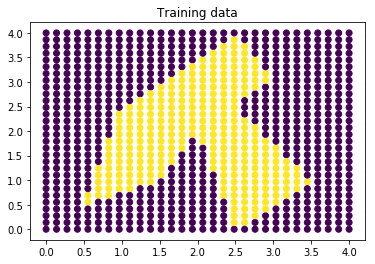

In [119]:
plot_train_data(x_train, y_train)

In [107]:
y_predicted = model.predict(x_train)

After 1000 epochs:


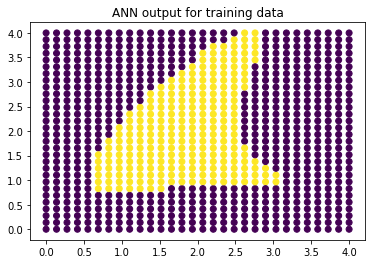

In [129]:
print("After 1000 epochs:")
plot_output(x_train, y_predicted)

==== Training ====
After 4000 epochs:


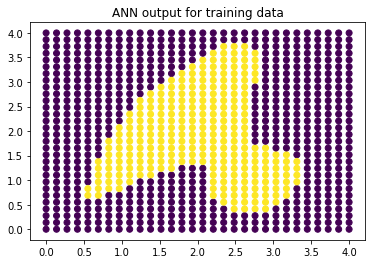

In [127]:
print("==== Training ====")
model2.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0)
y_predicted2 = model2.predict(x_train)
print("After 4000 epochs:")
plot_output(x_train, y_predicted2)